# Банки — Анализ оттока клиентов

## Ссылка на Дашборд: https://public.tableau.com/profile/agregatni#!/vizhome/Book2_15997821656810/Dashboard1?publish=yes

## Ссылка на Презентацию: https://cloud.mail.ru/public/2Tud/tpv99eM5Q

Цель: Проанализировать клиентов регионального банка и выделить портрет (аватар) клиентов, которые склонны уходить из банка.

### Шаг 1. Загрузка данных и предоработка данных

- проверим в данных пропуски, типы, аномалии, дубликаты, наименования колонок

### Шаг 2. Исследовательский анализ данных (EDA)

 - Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения;
 - Выясним нужно ли бороться с выбросами;

### Шаг 3. Выявление портрета клиента, склонных уходить из банка

 - Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
 - Построим графики и распределения признаков для тех, кто ушёл и тех, кто остался;
 - Построим матрицу корреляций и опишем портерет клиента;
 - Построим модель прогнозирования оттока пользователей;
 - Сделаем кластеризацию пользователей;

### Шаг 4. Формулировка и проверка статистических гипотез

- Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались.

### Шаг 5. Создание дашборда и презентации

- Диаграмма, отражающая количество клиентов в зависимости от числа используемых продуктов.;
- Добавить индикатор процента ушедших клиентов и фильтр дашборда по городу.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np


In [2]:
# задействуем фичи, от ошибок при повторном использовании одного и того же df
# и для отображения трёх символов после запятой для всех значений с плавающей запятой
# малые финансовые переменные любят 2 значения после запятой 
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# делаем загрузку с разных путей в зависимости от того, где запущена тетрадка - локально или на сервере ЯП
root_local = 'C:/Users/PC/проекты Яндекс/Датасеты/' #путь к данным при локальном запуске
root_yp = '/datasets/' #путь к данным при запуске на сервере ЯП
username = 'PC'
try:
    username = os.environ["USERNAME"]
except:
    pass
if(username == 'PC'): # локально
    root_path = root_local
else: # в тренажере
    root_path = root_yp
df = pd.read_csv(root_path + 'bank_dataset.csv')

In [4]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,nan,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,nan,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


* *Приведем все наименования столбцов к нижнему регистру*

In [6]:
df.columns = map(str.lower, df.columns)

* *Гендерное различие лучше будет анализировать в цифровом виде. Присвоим полу биномальные значения и изменим тип данны 

In [7]:
df['gender'] = df['gender'].replace('Ж','0').replace('М','1').astype('int')

* *Проверим дубликаты*

In [8]:
df.duplicated().sum()

0

#### Вывод: 
- колонки и данные предоработаны;
- дубликатов и пропусков не обнаружено, но не у всех на балансе есть деньги.

### Шаг 2. Исследовательский анализ данных (EDA)

 - Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения;
 - Выясним нужно ли бороться с выбросами;

In [9]:
df.head().T

,0,1,2,3,4
userid,15677338,15690047,15662040,15744090,15780624
score,619,608,502,699,850
city,Ярославль,Рыбинск,Ярославль,Ярославль,Рыбинск
gender,0,0,0,0,0
age,42,41,42,39,43
objects,2,1,8,1,2
balance,NaN,83807.86,159660.80,NaN,125510.82
products,1,1,3,2,1
creditcard,1,0,1,0,1
loyalty,1,1,0,0,1


* *Посмотрим природу географии клиентов*

In [10]:
df['city'].value_counts(True)

Ярославль        0.50
Ростов Великий   0.25
Рыбинск          0.25
Name: city, dtype: float64

*Преобразуем локации в численные значения*
- Ярославль - 1
- Ростов Великий - 2
- Рыбинск - 3

In [11]:
df['city'] = df['city'].replace('Ярославль','1').replace('Ростов Великий','2').replace('Рыбинск','3').astype('int')

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.00,15733676.57,71936.19,15608437.00,15671264.25,15733474.00,15795969.75,15858426.00
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
city,10000.00,1.75,0.83,1.00,1.00,1.00,2.00,3.00
gender,10000.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00


### Вывод:
- средний клиент со score 650;
- половина клиентов из Ярославля (1), остальные две четверти из Ростова(2) и Рыбинска(3).
- пол 50/50;
- возраст в среднем 38 лет;
- 5 объектов в собственности;
- использует около двух продуктов в банке;
- в среднем есть одна кредитная карта;
- половина из клиентов лояльны;
- зарплата в среднем 100 000 (не плохо для регионов);
- к оттоку склоны 20% из 100.

Стандартное отклонение очень разные у переменных *score*, *age*, *objects*, *balance*, *products*, *estimated_salary*. Возможно на это надо будет обратить внимание в дальнейшем.


### Шаг 3. Выявление портрета клиента, склонных уходить из банка

 - Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;


In [13]:
df.groupby(['churn']).mean().T.sort_values(by = 0, ascending = False)

churn,0,1
userid,15733903.88,15732787.96
balance,119535.86,120746.97
estimated_salary,99738.39,101465.68
score,651.85,645.35
age,37.41,44.84
objects,5.03,4.93
city,1.73,1.81
products,1.54,1.48
creditcard,0.71,0.70
gender,0.57,0.44


 - Построим графики и распределения признаков для тех, кто ушёл и тех, кто остался;

C:\Users\PC\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


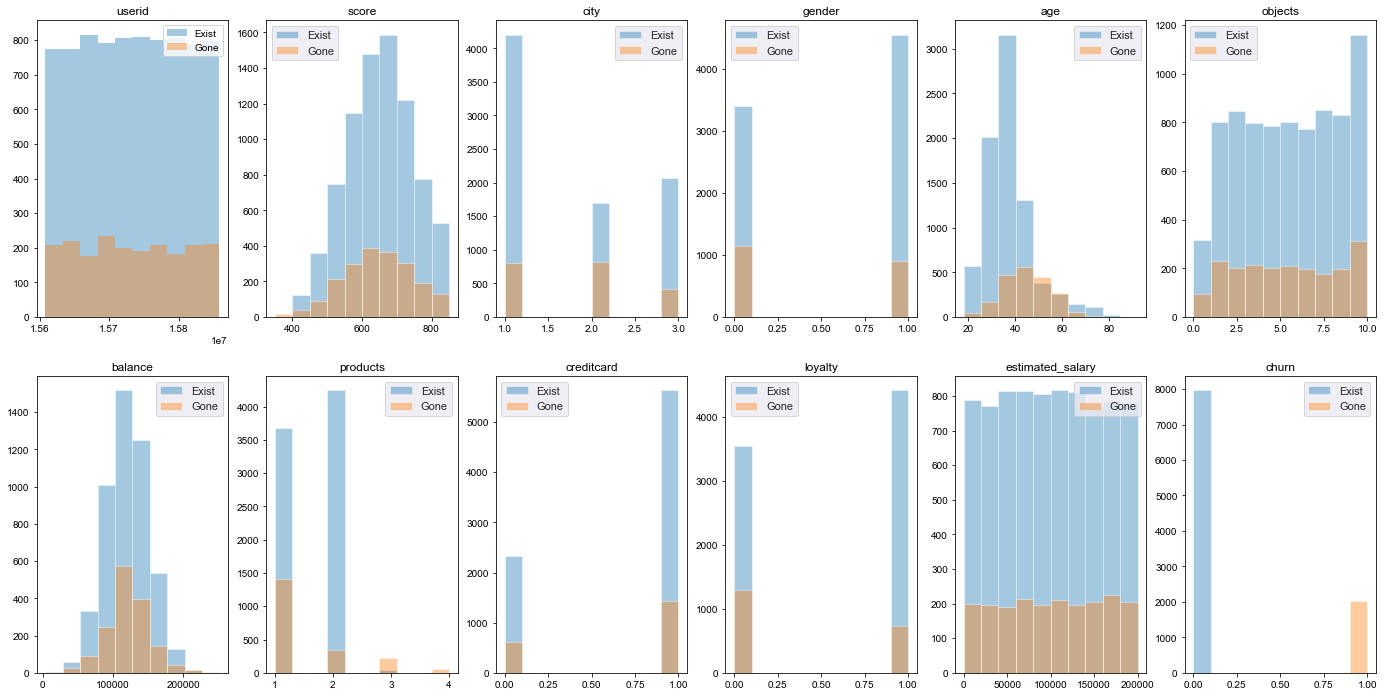

In [14]:
df_churn_0 = df[df['churn'] == 0] # сделаем фильтр тех кто ещё остался
df_churn_1 = df[df['churn'] == 1] # и тех кто уже ушёл

fig, ax = plt.subplots(2,6, figsize = (24,12))
ax = ax.ravel()

for i in range(len(df.columns)):
    col_name = df.columns[i]
    range_graph = (df[col_name].min(), df[col_name].max()) 
    sns.distplot(df_churn_0[col_name], ax=ax[i], kde=False, hist_kws = {'range': range_graph}, label='Exist', bins = 10, axlabel = False)      
    sns.distplot(df_churn_1[col_name], ax=ax[i], kde=False, hist_kws = {'range': range_graph}, label='Gone', bins = 10, axlabel = False)
    ax[i].legend()
    ax[i].set_title(col_name)
    sns.set()
    
plt.show()

### Вывод:
- низкий score у тех кто ушёл;
- в Рыбинске(3) клиенты уходят в два раза меньше чем, в Ярославле(1) и Ростове(2)
- пол на отток почти не влияет;
- к оттоку склонны все возрасты;
- доход по счёту, баланс и количество объектов не влияет на отток;
- оптимальное количество продуктов - 2 и 3,4 - продукта только у клиентов которые ушли;
- кредитные карты скорее влияют на отток, чем нет;
- низкая лояльность у клиентов которые ушли.
- весьма равномерная *заработная плата клиента* у всех клиентов



 - Построим матрицу корреляций и опишем портерет клиента.

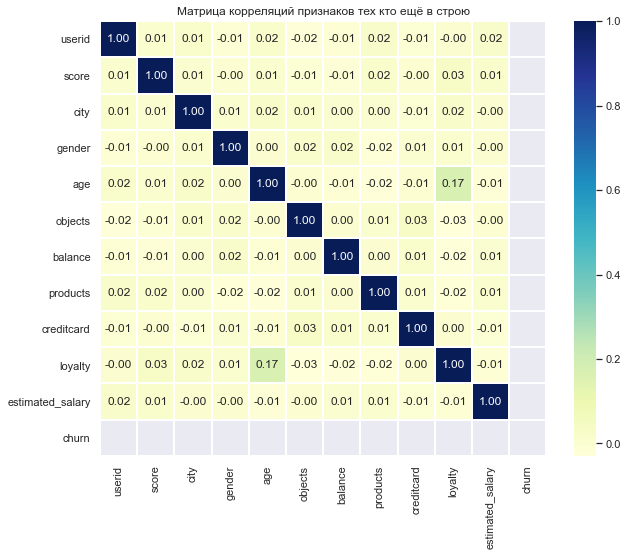

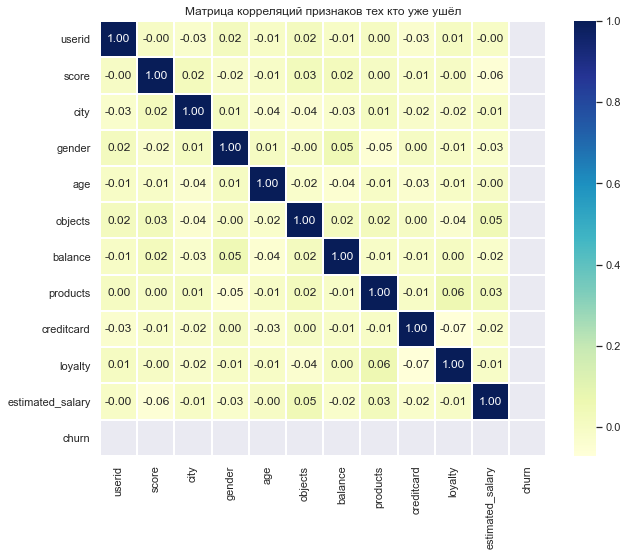

In [15]:
corr_m = df_churn_0.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_m, cmap="YlGnBu", annot = True, fmt='.2f', linewidths=1) 
plt.title('Матрица корреляций признаков тех кто ещё в строю');

corr_m = df_churn_1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_m, cmap="YlGnBu", annot = True, fmt='.2f', linewidths=1) 
plt.title('Матрица корреляций признаков тех кто уже ушёл');

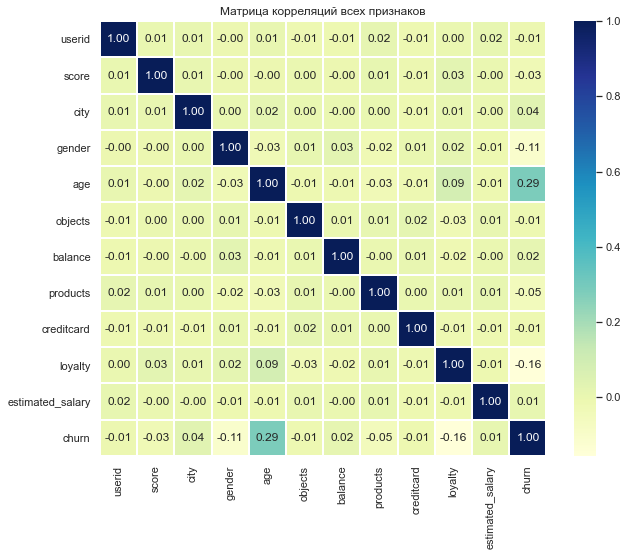

In [16]:
# с учетом оттока
corr_m = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_m, cmap="YlGnBu", annot = True, fmt='.2f', linewidths=1) 
plt.title('Матрица корреляций всех признаков');

#### Вывод: Немного корреклируется только возраст с оттком и лояльность клиента.

**Построим модель прогнозирования оттока клиентов**

**Построим модель бинарной классификации пользователей, где целевой признак — факт оттока клиента**

- Разобьём данные на обучающую и валидационную выборку функцией train_test_split().
- Обучим модель на train-выборке двумя способами:
    - логистической регрессией
    - случайным лесом


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [18]:
df = df.fillna(0) # заполним пропущенные значения на 0, чтобы не мешать обучению

In [19]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['churn']) 
y = df['churn']


In [20]:
# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [21]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
# Преобразуем обучающие и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [22]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression()
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [23]:
# создадим датафрейм с признаками и их весами
lr_features = pd.DataFrame({'features' : X_train.columns, 'coeff' : lr_model.coef_.ravel()}) # воспользуйтесь методом coef_
# обратим коэф-ты по модулю для оценки влияния на признаки 
lr_features['coeff_abs'] = abs(lr_features['coeff']) 
# выведите упорядоченный по модулю коэффициентов датафрейм с признаками
lr_features.sort_values('coeff_abs', ascending = False)

,features,coeff,coeff_abs
4,age,0.75,0.75
9,loyalty,-0.52,0.52
6,balance,0.30,0.30
3,gender,-0.27,0.27
2,city,0.10,0.10
5,objects,-0.08,0.08
1,score,-0.07,0.07
7,products,-0.05,0.05
10,estimated_salary,0.03,0.03
0,userid,0.02,0.02


**Вывод:** 
Самые важные признаки - `age` и `loyalty`

In [24]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [25]:
# создадим датафрейм с признаками и их весами
rf_features = pd.DataFrame({'feature' : X_train.columns, 'importance' : rf_model.feature_importances_}) # воспользуйтесь методом coef_

# выведите упорядоченный по модулю коэффициентов датафрейм с признаками
rf_features.sort_values('importance', ascending = False)

,feature,importance
4,age,0.22
7,products,0.12
0,userid,0.12
10,estimated_salary,0.12
6,balance,0.12
1,score,0.12
5,objects,0.07
9,loyalty,0.04
2,city,0.03
3,gender,0.02


**Вывод:** 
Самые важные признаки - `age`, `products`, `userid`, `estimated_salary`, `balance` и `score`. Логично!

-  Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. 

In [26]:
# определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [27]:
# посчитаем все метрики
print_metrics(y_test, lr_predictions, lr_probabilities, title = 'Метрики для модели логистической регрессии:')
print_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.81
	Precision: 0.56
	Recall: 0.18
Метрики для модели случайного леса:
	Accuracy: 0.87
	Precision: 0.75
	Recall: 0.50


**Вывод:** У случайного леса не только логика, но и метрики лучше! Логистическая регрессия ведёт себя хуже.

**Сделаем кластеризацию пользователей**

Стандартизируем данные и построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

In [28]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [29]:
# стандартизируем данные
sc = StandardScaler() # создаём объект класса scaler (нормализатор)
# обучаем нормализатор и преобразуем набор данных без учёта оттока, чтобы это не повлияло на модель
X_sc = sc.fit_transform(df.drop(columns = 'churn')) 

In [30]:
X_sc

array([[-0.78321342, -0.32622142, -0.90188624, ...,  0.64609167,
         0.97024255,  0.02188649],
       [-0.60653412, -0.44003595,  1.51506738, ..., -1.54776799,
         0.97024255,  0.21653375],
       [-0.99588476, -1.53679418, -0.90188624, ...,  0.64609167,
        -1.03067011,  0.2406869 ],
       ...,
       [-1.47928179,  0.60498839, -0.90188624, ..., -1.54776799,
         0.97024255, -1.00864308],
       [-0.11935577,  1.25683526,  0.30659057, ...,  0.64609167,
        -1.03067011, -0.12523071],
       [-0.87055909,  1.46377078, -0.90188624, ...,  0.64609167,
        -1.03067011, -1.07636976]])

In [31]:
# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

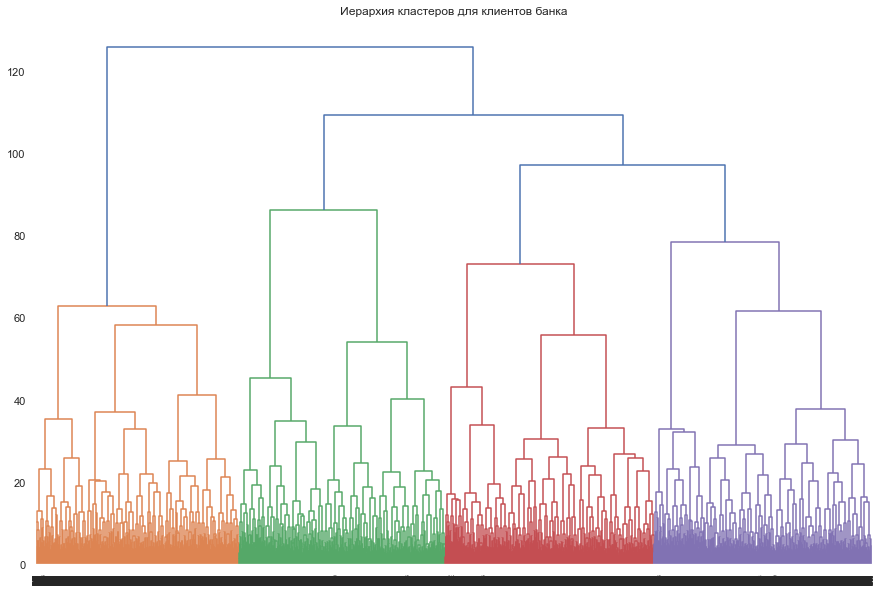

In [32]:
# визуализируем таблицу расстояний linked
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеров для клиентов банка')
plt.show()

**Вывод:** Получилось 4 кластера.

**Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Число кластеров принимаем n=4.**

In [33]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters = 4, random_state = 0) # 
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

In [34]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby(['cluster_km']).mean().sort_values('churn')

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
cluster_km,,,,,,,,,,,,
3,15735800.32,652.56,1.67,0.54,38.02,5.15,10574.58,2.15,0.98,0.53,99046.64,0.13
2,15732806.39,651.72,1.79,0.56,39.82,4.92,105515.19,1.28,1.00,1.00,98822.53,0.16
0,15735237.63,651.39,1.76,0.54,39.07,4.91,78715.94,1.50,0.00,0.52,100958.39,0.20
1,15730778.37,646.45,1.75,0.53,38.64,5.11,103860.56,1.26,1.00,0.00,101290.77,0.32


**Построим распределения признаков для кластеров.**

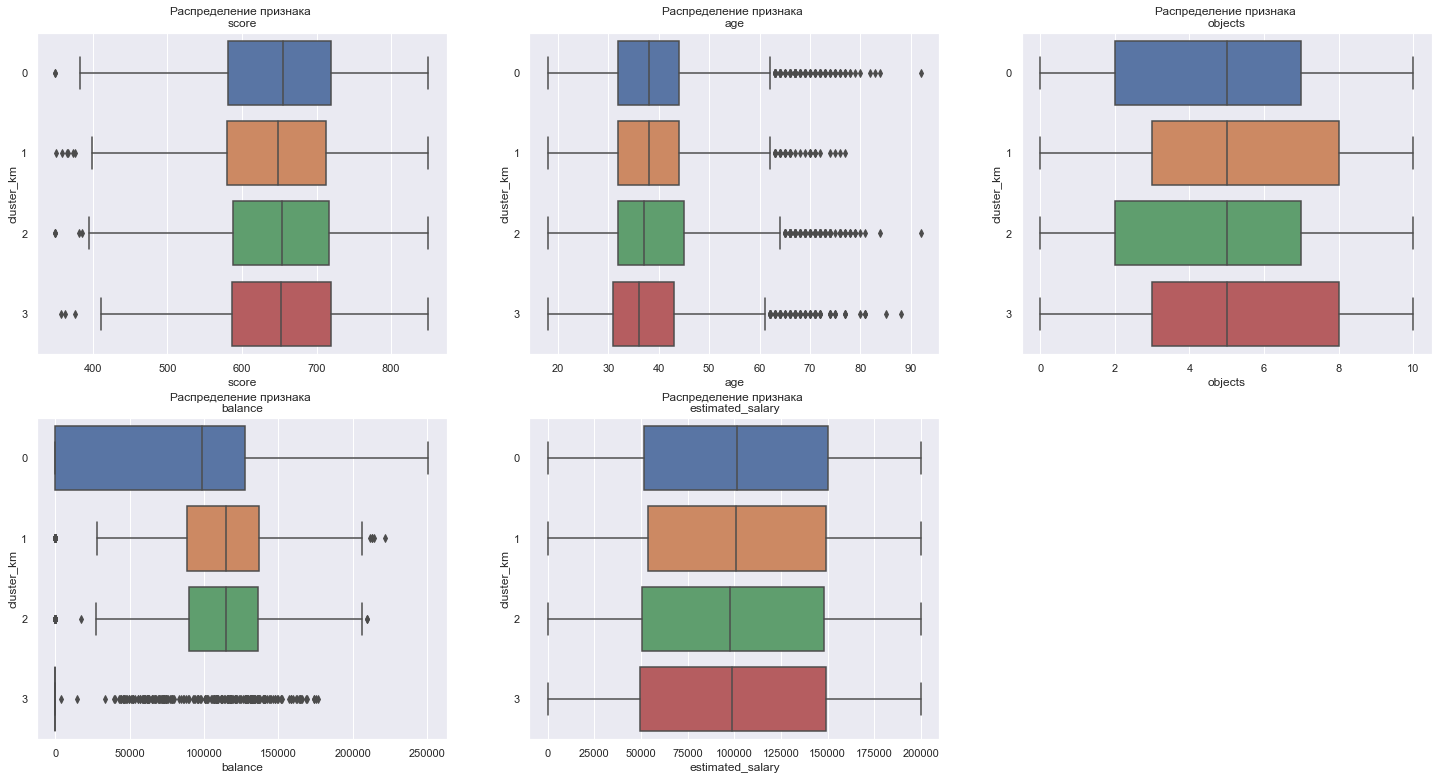

In [35]:
# для непрерывных признаков построим boxplot
cols_var = ['score', 'age', 'objects', 'balance', 'estimated_salary']
for i, col in enumerate(cols_var):
    plt.subplot(2, 3, i+1)
    fig = plt.gcf()
    fig.set_size_inches(25, 13)
    sns.boxplot(data = df, x = col, y = 'cluster_km', orient = 'h')
    plt.title('Распределение признака \n'+ str(col))

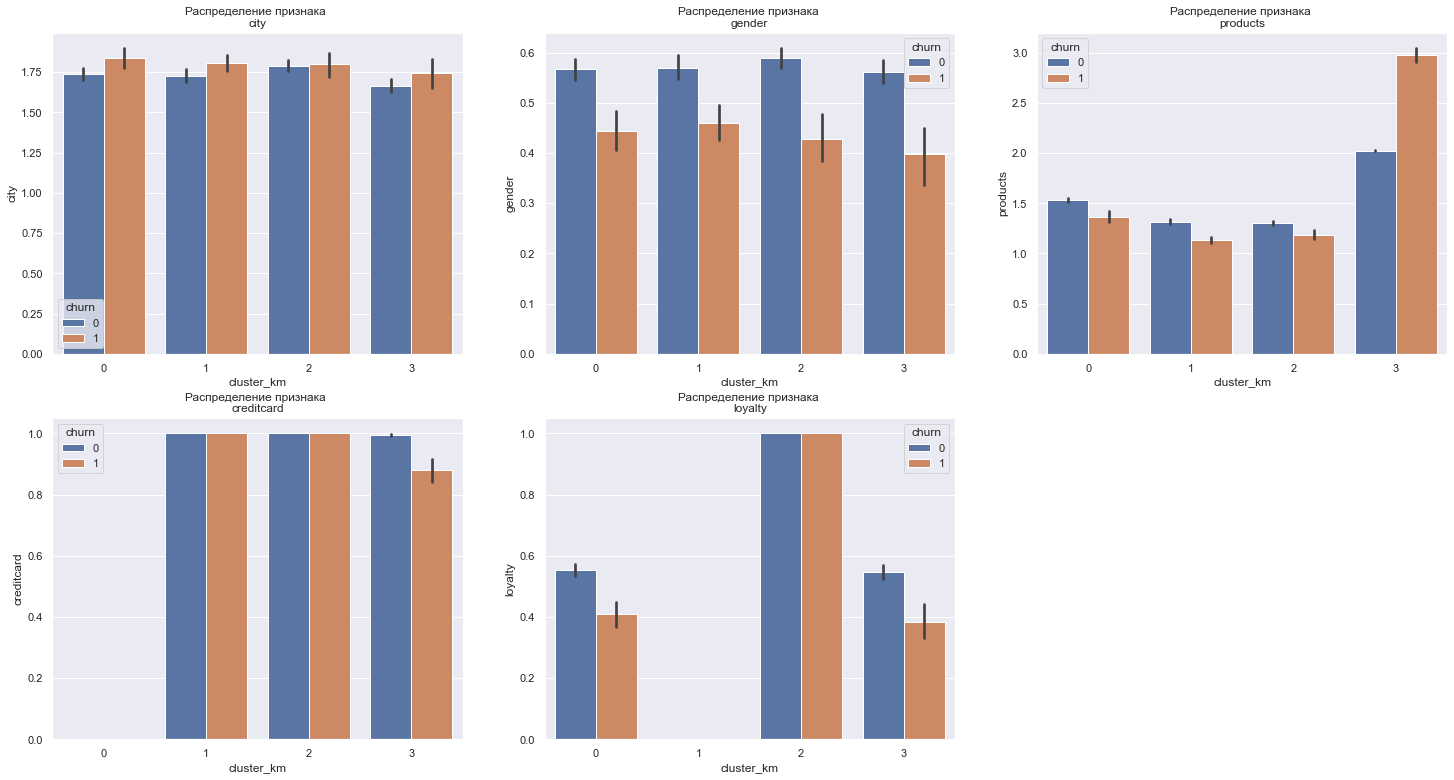

In [36]:
# для биномальных признаков построим столбчатый график
cols_binom = ['city', 'gender', 'products', 'creditcard', 'loyalty']

for i, col in enumerate(cols_binom):
    plt.subplot(2, 3, i+1)
    fig = plt.gcf()
    fig.set_size_inches(25,13)
    sns.barplot(data = df, x = 'cluster_km', y = col, hue = 'churn')
    plt.title('Распределение признака \n'+ str(col))

**Посчитаем долю оттока для каждого кластера**

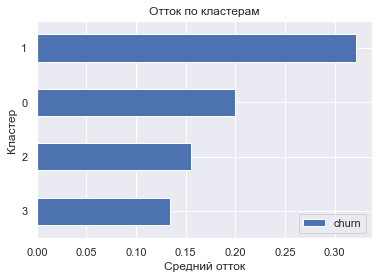

In [37]:
df.groupby(['cluster_km']).agg({'churn' : 'mean'}).sort_values('churn').plot(kind = 'barh')
plt.title('Отток по кластерам')
plt.xlabel('Средний отток')
plt.ylabel('Кластер');

**Вывод:**

`Класетр 1` - Беглецы. В среднем самый низкий баланс. Отсутствует какая-либо лояльность.

`Кластер 0, 2, 3`. Среднячки. Похожи по всем параметрам друг на друга. Но у `0` - нет кредиток. У `2` - высокая лояльность. `3` - самые высокие выбросы по балансу.

### Шаг 4. Формулировка и проверка статистических гипотез

- Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались.

Поскольку мы имеем дело со средними, то применим метод проверки гипотезы о равенстве двух средних

*Сформулируем гипотезы H0 и H1 для анализа долей:*

> Нулевая гипотеза H0 - "Нет оснований считать средние значения разными"

> Альтернативная гипотеза Н1 - "Между средними значениями есть значимая разница"

In [38]:
sample_1 = df_churn_0['estimated_salary'] # доход тех кто ушёл
sample_2 = df_churn_1['estimated_salary'] # и тех кто остался

alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    sample_1, 
    sample_2,
    equal_var = True) # т.к. выборки взяты из схожих по параметрам совокупностей укажем equal_var = True, это уточнит наш результат

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу. Между средними есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Нет оснований считать средние значения разными")

p-значение: 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу. Нет оснований считать средние значения разными


### Общий вывод:

1. Признаки, которые располагают к оттоку клиентов:
    - использование более двух продуктов в банке;
    - поддержание низкого баланса на счету;
    - локация в Рыбинске отток в половину меньше.
2. Рекомендации:
    - Не продавать более двух продуктов;
    - Желательно подсадить на кредитную карту;
3. Проверка гипотезы. Нет оснований считать средние между доходами значения разными. 